###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP
from littlegrad2.engine import Tensor

In [3]:
np.random.seed(1337)
random.seed(1337)

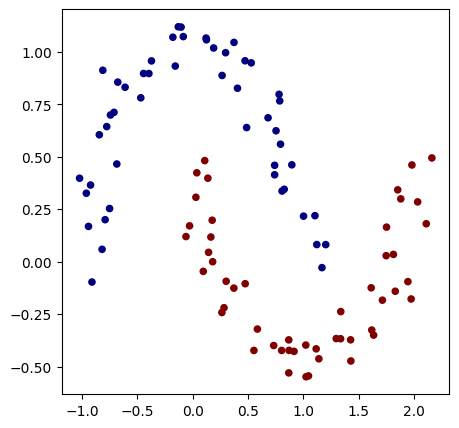

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
class LinearNet:
    def __init__(self):
        self.params = {
            #'w1' : Tensor(2 * np.random.random_sample((2, 25)) - 1),
            #'b1' : Tensor(np.zeros((1, 25))),
            #'w2' : Tensor(2 * np.random.random_sample((25, 15)) - 1),
            #'b2' : Tensor(np.zeros((1, 15))),
            #'w3' : Tensor(2 * np.random.random_sample((15, 2)) - 1),
            #'b3' : Tensor(np.zeros((1, 2)))

            'w1' : Tensor(np.random.randn(2, 25) * np.sqrt(2 / 2)), # 2 / (# of inputs from last layer)
            'b1' : Tensor(np.zeros((1, 25))),
            'w2' : Tensor(np.random.randn(25, 15) * np.sqrt(2 / 25)), # 2 / (# of inputs from last layer)
            'b2' : Tensor(np.zeros((1, 15))),
            'w3' : Tensor(np.random.randn(15, 2) * np.sqrt(2 / 15)), # 2 / (# of inputs from last layer)
            'b3' : Tensor(np.zeros((1, 2)))
        }

    def parameters(self):
        return self.params.values()
    
    def zero_grad(self):
        for param in self.params.values():
            param.grad *= 0
            
    def __call__(self, x:Tensor) -> Tensor:
        return ((x@self.params['w1']+self.params['b1']).relu()@self.params['w2']+self.params['b2']).relu()@self.params['w3']+self.params['b3']

model = LinearNet()
print(model.params)

{'w1': Tensor object with data [[-0.39906691 -0.03954993  0.49726636 -1.27807106  0.16834886  0.69125626
  -2.02769774  1.45418474  0.28589542  1.1815044  -0.85101893  0.81881018
  -1.47451856 -0.47910444  0.39517653 -1.66199178  1.51502301  1.56039682
  -0.74728008  0.68622584  0.30426816  0.74670675  0.11232295 -0.52722798
  -1.51150123]
 [-1.19037675  0.63740423 -0.89133682 -0.78245571  1.93852911 -0.93207158
  -0.15806274  0.57034558 -0.38496418 -0.34574031 -0.72397878 -0.82326108
   1.46730014  0.21003756  0.78097959  0.00413112  1.05795984  0.53583192
   0.56435244  0.39281759 -1.1791001  -0.19505764 -0.2892442  -0.43384018
  -0.81275923]], 'b1': Tensor object with data [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]], 'w2': Tensor object with data [[-5.15203001e-01 -1.17828510e-01  2.97484336e-01  4.76155764e-02
  -7.49114450e-02  1.91238346e-01 -4.22411339e-01 -1.68712522e-01
   2.71176831e-01  5.36869606e-01 -4.95395798e-02  1.98666263e-01
   1.

In [6]:
def softmax(logits):
  counts = np.e**(logits-np.max(logits.data)+1) #sum and max of .data don't affect grads cuz its just comparisons and additions?
  probs = counts / np.sum(counts.data)
  log_softmax = (logits-np.max(logits.data)+1) - np.log(np.sum(counts.data))
  return probs, log_softmax

#X = (X-np.average(X)) / np.std(X)  #data normalization
def loss(batch_size=None):

    if batch_size is None:  #dataloader
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] #shuffles the X indexes and returns the first 10
        Xb, yb = X[ri], y[ri]

    losses, accuracy = [], []
    for (xrow, yrow) in zip(Xb, yb):
        probs, log_softmax = softmax(model(Tensor(xrow)))
        losses.append(-log_softmax @ Tensor([index == yrow for index in range(log_softmax.data.size)]).transpose())
        accuracy.append(yrow == np.argmax(probs.data))
    #total_loss = sum(losses) / len(losses)
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p.flatten()@p.flatten().transpose() for p in model.parameters()))
    total_loss = data_loss + reg_loss
    return total_loss, sum(accuracy) / len(accuracy)


In [7]:
learning_rate, beta1, beta2, epsilon, v_dp, s_dp = 0.0001, 0.9, 0.999, 1e-8, 0, 0
# optimization
for k in range(200):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backprop()
    
    # update (sgd)
    #learning_rate = 1.0 - 0.9*k/100
    #learning_rate = 0.01
    for p in model.parameters():
        print(1)
        #p.data -= learning_rate * p.grad

        v_dp = (beta1 * v_dp) + ((1-beta1) * p.grad)
        s_dp = (beta2 * s_dp) + ((1-beta2) * (p.grad**2))
        v_dp_corrected = v_dp / (1 - (beta1**(k+1)))
        s_dp_corrected = s_dp / (1 - (beta2**(k+1)))
        p.data -= learning_rate * v_dp_corrected / (np.sqrt(s_dp_corrected) + epsilon)
        print(2)
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


1
2
1


ValueError: non-broadcastable output operand with shape (1,25) doesn't match the broadcast shape (2,25)

(-1.548639298268643, 1.951360701731357)

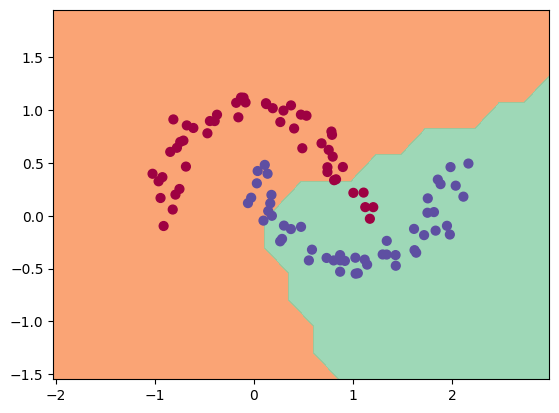

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#scores = list(map(model, inputs))
#scores = list(map(model, [Tensor(xi) for xi in Xmesh]))
scores = []
for xrow in Xmesh:
    probs, log_softmax = softmax(model(Tensor(xrow)))
    scores.append(np.argmax(probs.data))

#Z = np.array([s.data > 0 for s in scores])
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
